In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making pictures
%matplotlib inline

In [10]:
# read in all the words

words = open('names.txt', 'r').read().splitlines()

In [11]:
chars = sorted(list(set(''.join(words))))
len(chars)
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [12]:
block_size = 3 # how many texts do we take to predict the next one

def bulit_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = bulit_dataset(words[:n1])
Xdev, Ydev = bulit_dataset(words[n1:n2])
Xtest, Ytest = bulit_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [13]:
Xtr.shape[0]

182625

In [14]:
# MLP revised
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of the neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# batch normalization parameters



parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True





11897


In [ ]:
# same optimization at last time
max_step = 200000
batch_size = 32
lossi = []

for i in range(max_step):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y

    #forward pass
    emb =C[Xb] #embed the characters intp vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    #Linear layer
    hpreact = embcat @ W1 + b1# hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    #BatchNorm layer


    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    # track states
    if i % 10000 ==0: # print every once in a while
        print(f'{i:7d}/{max_step:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())



      0/ 200000:3.3196
  10000/ 200000:2.2029
  20000/ 200000:2.0766
  30000/ 200000:1.9351
  40000/ 200000:2.1812
  50000/ 200000:2.1393
  60000/ 200000:2.1324
  70000/ 200000:2.1964
  80000/ 200000:2.6778
  90000/ 200000:2.2916
 100000/ 200000:2.3376
 110000/ 200000:2.0448
 120000/ 200000:2.0751
 130000/ 200000:2.3233
 140000/ 200000:2.0601
 150000/ 200000:2.1581
 160000/ 200000:2.6017
 170000/ 200000:2.1070
 180000/ 200000:2.0783
 190000/ 200000:1.8585


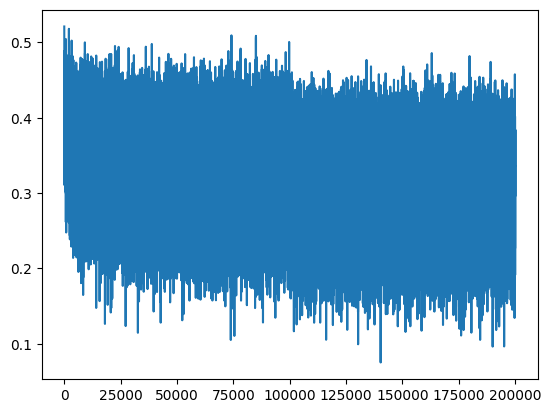

In [20]:
plt.plot(lossi)

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) 
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 +b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.037872791290283
val 2.107177972793579


In [ ]:
# ample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # intialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.ranh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '. token brak
        if ix == 0:
            break

    print(''.join(itos[i] for i in out) ) # decode and print the generated word 